### ECE-GY 6123
### Nikita Makarov, Fall 2024

### Homework 3

Problem 1a:

In [20]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

# Create Gaussian Pyramid function
def gaussian_pyramid(im_data: np.ndarray, J: int) -> list[np.ndarray]:
    '''
    Compute and return the J-level Gaussian pyramid decomposition of a grayscale image.

    Parameters:
    im_data: 2D numpy array of the image data in grayscale
    J: int of the Gaussian pyramid level

    Returns:
    G: list of size J filled with 2D numpy arrays of the Gaussian pyramid, with the first element being level 0
    '''

    # Create Gaussian pyramid structure
    G = [im_data] # Create list with last element as level J

    # Iterate over all remaining levels
    for _ in range(0,J-1):
        width = int(im_data.shape[1]/2) # Calculate new width
        height = int(im_data.shape[0]/2) # Calculate new height
        im_data = cv2.resize(im_data,(width,height),interpolation=cv2.INTER_LINEAR) # Get next layer of image data
        G.insert(0, im_data) # Add new layer to front of list

    return G

# Create Laplacian Pyramid function
def laplacian_pyramid(im_data: np.ndarray, J: int) -> list[np.ndarray]:
    '''
    Compute and return the J-level Laplacian pyramid decomposition of a grayscale image.

    Parameters:
    im_data: 2D numpy array of the image data in grayscale
    J: int of the Laplacian pyramid level

    Returns:
    L: list of size J filled with 2D numpy arrays of the Laplacian pyramid, with the first element being level 0
    '''

    # Calculate Gaussian pyramid structure
    G = gaussian_pyramid(im_data, J)

    # Create Laplacian pyramid structure
    L = [G.pop(0)] # Create list with first element as level 0

    # Iterate over all remaining levels
    for i in range(0,J-1):
        im_data = G.pop(0) # Get first element in Gaussian pyramid
        (height,width) = im_data.shape # Get new width and height
        U = cv2.resize(L[i],(width,height),interpolation=cv2.INTER_CUBIC) # Perform upscaling for next layer
        L.append(im_data - U) # Add new layer to end of list

    return L


Problem 1b:

KeyboardInterrupt: 

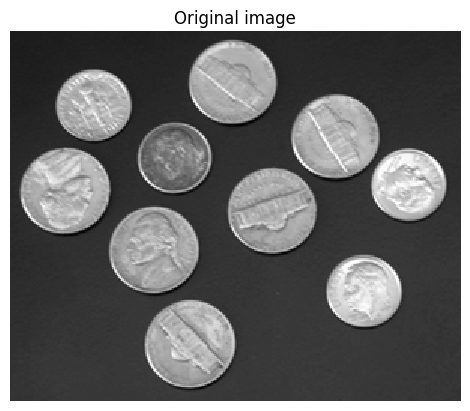

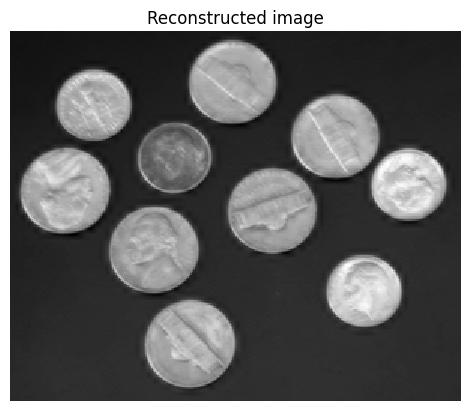

In [37]:
# Create Laplacian reconstruction function
def reconstruct_laplacian(L: list[np.ndarray]) -> np.ndarray:
    '''
    Reconstruct and return a grayscale image from a Laplacian pyramid structure.

    Parameters:
    L: list of size J filled with 2D numpy arrays of the Laplacian pyramid, with the first element being element 0

    Returns:
    R: 2D numpy array of the reconstructed image in grayscale
    '''

    # Create reconstructed image structure
    R = L[0]

    # Iterate over levels of the laplacian pyramid
    for i in range(0,len(L)-1):
        (height,width) = L[i+1].shape # Get new width and height
        U = cv2.resize(R,(width,height),interpolation=cv2.INTER_CUBIC) # Perform upscaling for next layer
        R = L[i+1] + U # Calculate new reconstructed layer

    return R

# Create function for composite arrays for image display
def composite_image(P: list[np.ndarray]) -> np.ndarray:
    '''
    Create a composite array from a Gaussian or Laplacian pyramid structure.

    Parameters:
    P: list filled with 2D numpy arrays of the Gaussian or Laplacian pyramids, with the first element being element 0

    Returns:
    C: 2D numpy array of the composite image
    '''

    # Create initial composite array
    height = max(np.shape(P[-1])[0],sum([np.shape(x)[0] for x in P[:-1]]))
    width = np.shape(P[-1])[1] + np.shape(P[-2])[1]
    C = np.full((height, width), np.nan)
    pass

# Test reconstruction with a sample image
image = np.asarray(cv2.imread('coins.png', cv2.IMREAD_GRAYSCALE),dtype=float)
G = gaussian_pyramid(image, 3) # Gaussian pyramid
L = laplacian_pyramid(image, 3) # Laplacian pyramid
R = reconstruct_laplacian(L) # Reconstructed image

# Create figure for original image
plt.figure()
plt.imshow(image, interpolation='none', cmap='gray')
plt.title('Original image')
plt.axis('off')

# Create figure for reconstructed image
plt.figure()
plt.imshow(R, interpolation='none', cmap='gray')
plt.title('Reconstructed image')
plt.axis('off')

comp = composite_image(G)